# Typical Steam Demand for UIUC

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Upload data

In [2]:
# define path to data
path = "../../data/" 

In [3]:
# upload datasets
steam15 = pd.read_csv(path+'steamfy15.csv', parse_dates=True, index_col=['Date and Time'])
steam16 = pd.read_csv(path+'steamfy16.csv', parse_dates=True, index_col=['Date and Time'])
steam17 = pd.read_csv(path+'steamfy17.csv', parse_dates=True, index_col=['Date and Time'])
steam18 = pd.read_csv(path+'steamfy18.csv', parse_dates=True, index_col=['Date and Time'])
steam19 = pd.read_csv(path+'steamfy19.csv', parse_dates=True, index_col=['Date and Time'])

## Combine the datasets

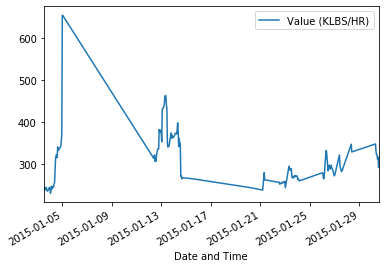

In [4]:
steam15[(steam15['eDNA Status as String'] == 'UNRELIABLE') & (steam15.index.month <= 1)].plot()

In [5]:
frames = [steam15, steam16, steam17, steam18, steam19]

all_data = pd.concat(frames)

# all_data

In [6]:
all_data.head()

,Value (KLBS/HR),eDNA Status as String
Date and Time,,
2014-07-01 00:00:00,105.872467,UNRELIABLE
2014-07-01 01:00:00,104.659416,UNRELIABLE
2014-07-01 02:00:00,105.016411,UNRELIABLE
2014-07-01 03:00:00,106.378754,UNRELIABLE
2014-07-01 04:00:00,106.899544,UNRELIABLE


There is some data marked as 'UNRELIABLE' by eDNA, but it looks mostly okay, except for a couple of days in 2015 that show 0 demand in the winter. We can fix that by interpolating. It looks like the worst data is confined to 2014, which we don't want to use anyway because we can only use complete years of data. 

## Separate the data into complete years

In [7]:
all_data.drop(['eDNA Status as String'], axis=1, inplace=True)

In [8]:
all_data.rename(columns = {'Value (KLBS/HR)':'demand'}, inplace=True)

all_data.head()

,demand
Date and Time,
2014-07-01 00:00:00,105.872467
2014-07-01 01:00:00,104.659416
2014-07-01 02:00:00,105.016411
2014-07-01 03:00:00,106.378754
2014-07-01 04:00:00,106.899544


In [9]:
years = all_data.groupby(all_data.index.year)

steam_data15 = years.get_group(2015)
steam_data16 = years.get_group(2016)
steam_data17 = years.get_group(2017)
steam_data18 = years.get_group(2018)

## Preparing the datasets to be used in RAVEN

This data will be read by RAVEN as HistorySets (a datatype of RAVEN) and will have two columns 

time | demand

where ``time`` is in hours and ``demand`` is in klbs/hr

In [10]:
%%capture
steam_data15.reset_index(inplace=True)
steam_data15['time'] = steam_data15.index
steam_data15.drop(['Date and Time'], axis=1, inplace=True)
steam_data15.head()

In [11]:
%%capture
steam_data16.reset_index(inplace=True)
steam_data16['time'] = steam_data16.index
steam_data16.drop(['Date and Time'], axis=1, inplace=True)
steam_data16 = steam_data16[:8760]
steam_data16.head()

In [12]:
%%capture
steam_data17.reset_index(inplace=True)
steam_data17['time'] = steam_data17.index
steam_data17.drop(['Date and Time'], axis=1, inplace=True)
steam_data17.head()

In [13]:
%%capture
steam_data18.reset_index(inplace=True)
steam_data18['time'] = steam_data18.index
steam_data18.drop(['Date and Time'], axis=1, inplace=True)
steam_data18.head()

## Download the RAVEN datasets

In [14]:
# writes the header file for RAVEN
fname = 'annual_steam201'
keys = [fname + str(i) + '.csv' for i in range(5,9,1)]
header_file = pd.DataFrame({'n':np.zeros(len(keys), dtype=np.int8), 'filename':keys})
header_file.to_csv(path+'annual_steam_H.csv')
print(keys)

['annual_steam2015.csv', 'annual_steam2016.csv', 'annual_steam2017.csv', 'annual_steam2018.csv']


In [15]:
steam_data15.to_csv(path+'annual_steam2015.csv')
steam_data16.to_csv(path+'annual_steam2016.csv')
steam_data17.to_csv(path+'annual_steam2017.csv')
steam_data18.to_csv(path+'annual_steam2018.csv')

In [16]:
!ls ~/Research/data/

2014_2019_uiuc_electricity_demand.csv  __MACOSX
2015_uiuc_electricity_demand.csv       solardata_2015.csv
2016_uiuc_electricity_demand.csv       solardata_2016.csv
2017_uiuc_electricity_demand.csv       solardata_2017.csv
2018_uiuc_electricity_demand.csv       solardata_2018.csv
2019_uiuc_electricity_demand.csv       solardata_2019.csv
annual_load2015.csv		       solardata.csv
annual_load2016.csv		       solar_farm_data
annual_load2017.csv		       solar_model_data
annual_load2018.csv		       steam_data
annual_load_H.csv		       steamfy15.csv
annual_steam2015.csv		       steamfy16.csv
annual_steam2016.csv		       steamfy17.csv
annual_steam2017.csv		       steamfy18.csv
annual_steam2018.csv		       steamfy19.csv
annual_steam_H.csv		       TypicalDemand_0.csv
dni_2012.csv			       TypicalDemand.csv
dni_2013.csv			       TypicalDemand.xml
dni_2014.csv			       TypicalSolar_0.csv
dni_2015.csv			       TypicalSolar.csv
dni_2016.csv			       TypicalSolar.xml
dni_2017.csv			       TypicalSteam

In [17]:
!~/Research/raven/raven_framework ~/Research/2020-dotson-optimal-sizing/inputfiles/typical_steam.xml

CONDA
raven_libraries          /home/dotson/anaconda3/envs/raven_libraries
Running RAVEN in "opt" mode.
/home/dotson/Research/raven/framework/utils/utils.py:579: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp, os.path
/home/dotson/anaconda3/envs/raven_libraries/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/home/dotson/anaconda3/envs/raven_libraries/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/home/dotson/anaconda3/envs/raven_libraries/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'colle

(    0.04 sec) HistorySet               : DEBUG           -> Reading data from "/home/dotson/Research/data/annual_steam2016.csv.csv"
(    0.05 sec) HistorySet               : DEBUG           -> Reading data from "/home/dotson/Research/data/annual_steam2017.csv.csv"
(    0.06 sec) HistorySet               : DEBUG           -> Reading data from "/home/dotson/Research/data/annual_steam2018.csv.csv"
(    0.07 sec) STEP IOCOMBINED          : Message         -> ***       Run finished        ***
(    0.07 sec) STEP IOCOMBINED          : Message         -> ***     Closing the step      ***
(    0.07 sec) STEP IOCOMBINED          : Message         -> ***        Step closed        ***
(    0.07 sec) SIMULATION               : Message         -> -- End step read of type: IOStep                               --

(    0.07 sec) SIMULATION               : Message         -> -- Beginning step get_history of type: PostProcess                  --
(    0.07 sec) STEP SINGLERUN           : Message       

(    0.25 sec) HistorySet               : DEBUG           -> Printing metadata XML: "TypicalSteam.xml"
(    0.25 sec) STEP IOCOMBINED          : Message         -> ***       Run finished        ***
(    0.25 sec) STEP IOCOMBINED          : Message         -> ***     Closing the step      ***
(    0.25 sec) STEP IOCOMBINED          : Message         -> ***        Step closed        ***
(    0.25 sec) SIMULATION               : Message         -> -- End step write of type: IOStep                              --

--------------------------------------------------
There were 1 warnings during the simulation run:
(1 time) DataObject._convertToDict can be a slow operation and should be avoided where possible!
--------------------------------------------------
(    0.25 sec) SIMULATION               : Message         -> Run complete!


In [18]:
typical_steam = pd.read_csv(path+"TypicalSteam_0.csv")

typical_steam['date'] = pd.date_range(start='1/1/2018', end='1/1/2019', freq='H')[:8760]

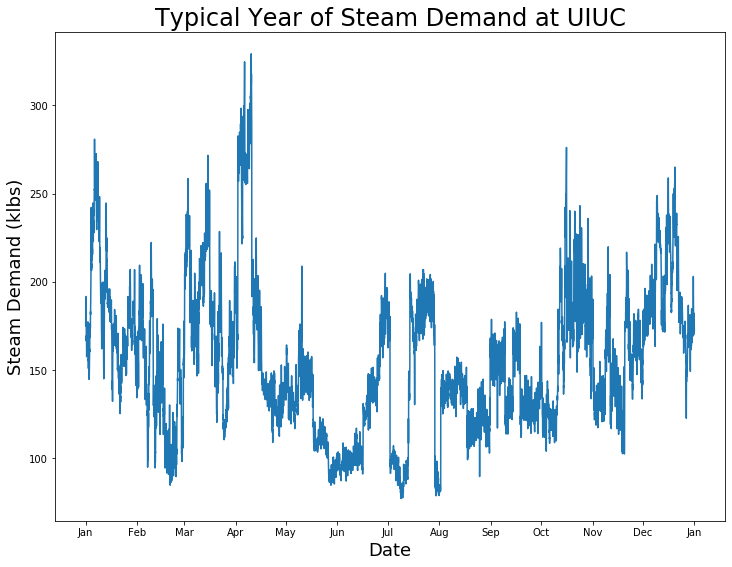

In [19]:
import matplotlib.dates as mdates


# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

fig = plt.figure(figsize=(12,9), edgecolor='k', facecolor='w')
plt.plot(typical_steam.date, typical_steam.demand)
plt.title('Typical Year of Steam Demand at UIUC', fontsize=24)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Steam Demand (klbs)',fontsize=18)

X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.show()